<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

This script is used to realize unsupervised machine learning (self-organizing maps) of difference of temperature betweeen ERA5 and MOSAiC.

### IMPORT

In [1]:
from netCDF4 import Dataset as ncfile
from netCDF4 import num2date
import matplotlib.dates as dates
from minisom import MiniSom
import time
import numpy as np
import matplotlib.pyplot as plt
from pylab import colorbar
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy.linalg import norm
import sys
import numpy.ma as ma
import cartopy
import pandas as pd
import datetime
import pickle

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

### READ DATA

In [2]:
ppidir = '/home/jcharrel/Documents/M1_internship/lustre/storeB/users/justinec/master_internship/data/ERA5_MOSAiC/'
data_link  = ppidir + 'concatenated_ERA5_MOSAiC.nc'

dataset = ncfile(data_link,'r')    #dataset of radiosoundings of MOSAiC and ERA5

In [3]:
pres = dataset.variables['pres'][:]
era5_rh = dataset.variables['rh_era5'][:]
mosaic_rh = dataset.variables['rh_mosaic'][:]
era5_temp = dataset.variables['temp_era5'][:]
mosaic_temp = dataset.variables['temp_mosaic'][:]
era5_sh = dataset.variables['sh_era5'][:]
mosaic_sh = dataset.variables['sh_mosaic'][:]
mosaic_time = dataset.variables['time_mosaic'][:]
mosaic_lat = dataset.variables['lat_mosaic'][:]
mosaic_lon = dataset.variables['lon_mosaic'][:]

In [4]:
"""Function that convert times of a dataset depemding on its unit and calendar 
type to a datetime then to Matplotlib dates.
---exemple---
ERA5 :  'hours since 1900-01-01 00:00:00.0' become datetime of type 2019-10-01 00:00:00 then 18170
MOSAiC : 'seconds since 2019-10-31T22:55:09.757Z' become datetime of type 2019-10-31 22:55:09.757000 then 18200.954974039352
"""
def convert_time(dataset) :
    dataset_time = dataset.variables['time_mosaic']
    t_unit = dataset_time.units
    t_cal = dataset_time.calendar
    dataset_nctime=[]; 
    dataset_nctime.append(num2date(dataset_time,units = t_unit,calendar = t_cal, only_use_python_datetimes=True, only_use_cftime_datetimes=False)) #datetime of type 2019-10-01 00:00:00
    #dates.date2num --> convert datetime objects to Matplotlib dates (better for compare ERA5 and MOSAiC times and for figures)
    #np.squeeze --> pass Matplotlib dates in column instead of in line
    dataset_nctimenum = np.squeeze(dates.date2num(dataset_nctime))
    return dataset_nctime,dataset_nctimenum,t_unit

In [5]:
nctime, nctimenum, t_unit = convert_time(dataset)

### REPLACE MASKED/NAN VALUES BY INTERPOLATION BETWEEN NEAREST VALUES

In [6]:
mosaic_rh = np.ma.masked_object(mosaic_rh, mosaic_rh[559][11]) # mask outlier value

In [7]:
def replacenan(var) :
    new_var = np.zeros((1399,29))
    for i in range(0,len(var)) :
        for j in range(0,len(var[i])) :
            if ma.getmask(var)[i][j] == True :
                #print('masked value in {}, {}'.format(i,j))
                if j == 28 :
                    #print('value in j-1 : {}, value in j-2 : {}'.format(var[i][j-1],var[i][j-2]))
                    new_var[i][j] = var[i][j-1]+(var[i][j-1]-var[i][j-2])
                    #print('new value :', new_var[i][j])
                else :
                    #print(var[i][j-1],var[i][j+1])
                    new_var[i][j] = np.mean([var[i][j-1],var[i][j+1]])
                    #print(new_var[i][j])
            else :
                new_var[i][j] = var[i][j]  
    return new_var

In [8]:
new_mosaic_temp = replacenan(mosaic_temp)
print('nan values temp:', ma.count_masked(new_mosaic_temp)) # verify there is no masked/nan values
temp_bias = era5_temp-new_mosaic_temp # bias of temperature between ERA5 and MOSAiC
data = temp_bias

new_mosaic_rh = replacenan(mosaic_rh)
print('nan values rh:', ma.count_masked(new_mosaic_rh)) # verify there is no masked/nan values
rh_bias = era5_rh-new_mosaic_rh # bias of relative humidity between ERA5 and MOSAiC

sh_bias = era5_sh-mosaic_sh # bias of specific humidity between ERA5 and MOSAiC
print('nan values sh:', ma.count_masked(mosaic_sh)) # verify there is no masked/nan values

nan values temp: 0
nan values rh: 0
nan values sh: 0


In [9]:
temp_bias_list = temp_bias.tolist()

# remove profiles of neuron 1 and 5
#indx_nan = [189,331,408,637,699,880,991]
#for i in range(0,len(indx_nan)) :
#    temp_bias_list.pop(indx_nan[i])
#print(len(temp_bias_list))

In [10]:
data = temp_bias_list

### SELF-ORGANIZING MAPS

#### Set hyperparameters

In [11]:
x = 4
y = 4
input_len = len(data[1])
iterations = 10000
sigma = 0.4
learning_rate = 0.2

#### Train and plot SOM

In [12]:
def train_som(x, y, input_len, sigma, learning_rate):
    
    # initialization of x*y SOM
    som = MiniSom(x=x, 
                  y=y, 
                  input_len=input_len, 
                  sigma=sigma, 
                  learning_rate=learning_rate, 
                  random_seed=10)
    som.random_weights_init(data)
    
    # training
    start_time = time.time()
    som.train_random(data,iterations)
    elapsed_time = time.time() - start_time
    #print(elapsed_time, "seconds")
    print('total_q_error :', som.quantization_error(data))
    
    return som

In [13]:
#som = train_som(x, y, input_len, sigma, learning_rate)

#### Load SOM

In [14]:
path_som = '/home/jcharrel/Documents/M1_internship/lustre/storeB/users/justinec/master_internship/data/SOM/'
with open(path_som + 'som_era5_mosaic_bias_temp.p', 'rb') as infile:
    som = pickle.load(infile)

#### Distance map between each neuron

In [15]:
def plot_som(som):
    plt.figure(figsize=(6, 6))
    plt.imshow(som.distance_map()) #normalised sum of the distances between a neuron and its neighbours (euclidean distance)
    plt.colorbar()
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, 4, 1))
    ax.set_yticks(np.arange(-.5, 4, 1))
    ax.set_xticklabels(np.arange(0, 5, 1))
    ax.set_yticklabels(np.arange(0, 5, 1))

In [16]:
som.distance_map()

array([[0.17575165, 0.24469406, 0.18093785, 0.02353678],
       [0.19110373, 1.        , 0.19948916, 0.02395235],
       [0.14852024, 0.17140668, 0.18431183, 0.05471008],
       [0.01907207, 0.02787239, 0.05884094, 0.04467713]])

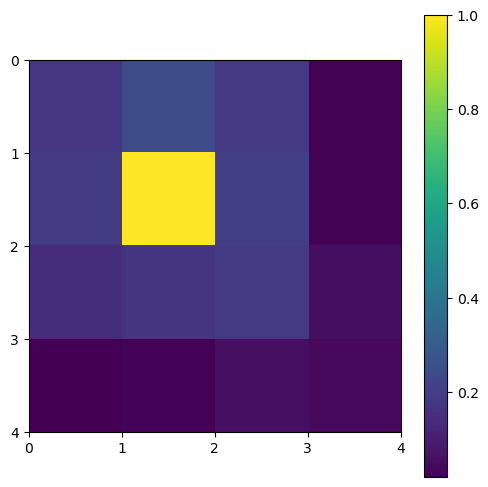

In [17]:
plot_som(som)

#### QUANTIZATION TOPOGRAPHIC ERRORS OVER ITERATIONS

iteration=99999 status=100.00% error=2.5803457205658757

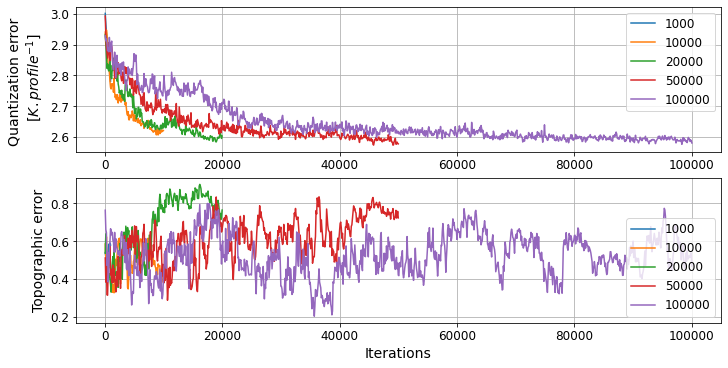

In [17]:
parameters = {'axes.labelsize':14, 'axes.titlesize':12, 'legend.fontsize':12, 'xtick.labelsize':12, 'ytick.labelsize':12, 
                  'legend.title_fontsize':10, 'figure.titlesize':25}
plt.rcParams.update(parameters)

max_iter = [1000,10000,20000,50000,100000]

fig, axs = plt.subplots(2,1,figsize=(10,5), constrained_layout=True)
for num_iter in max_iter:
    som_test = MiniSom(x, y, input_len=input_len, sigma=sigma, learning_rate=learning_rate, 
                  neighborhood_function='gaussian', random_seed=10)
    som_test.random_weights_init(data)
    
    q_error_list = [] ; t_error_list = [] ; iter_x = []
    for i in range(num_iter):
        percent = 100*(i+1)/num_iter
        rand_i = np.random.randint(len(data))
        som_test.update(data[rand_i], som_test.winner(data[rand_i]), i, num_iter)
        if (i+1) % 100 == 0:
            q_error = som_test.quantization_error(data)
            t_error = som_test.topographic_error(data)
            q_error_list.append(q_error)
            t_error_list.append(t_error)
            iter_x.append(i)
            sys.stdout.write(f'\riteration={i:2d} status={percent:0.2f}% error={q_error}')
    axs[0].plot(iter_x,q_error_list, label='{}'.format(num_iter))
    axs[1].plot(iter_x,t_error_list, label='{}'.format(num_iter))
axs[0].set_ylabel('Quantization error \n [$K.profile^{{-1}}$]')
axs[1].set_ylabel('Topographic error')
axs[1].set_xlabel('Iterations')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_SOM/'
plt.savefig(path_fig+'ERA5_MOSAIC_bias_temp_'+str(x*y)+'_s'+str(sigma)+'_lt'+str(learning_rate)+'_i'+str(iterations)+'_qerror.png', dpi=300, facecolor='white', transparent=False)
#it converges faster with fewer iterations because the learning rate decreases when the number of iterations increases

#### Parameters from minisom library, usefull for plot

In [18]:
neuron_weights = som.get_weights()           # neuron weights for each neuron
win_map = som.win_map(data)                  # profiles sort by indices of neuron
nb_profiles = som.activation_response(data)  # number of profiles in each neuron
print('number of profiles : \n', nb_profiles)

number of profiles : 
 [[ 34.   2. 245.  62.]
 [ 55.   5.  73. 127.]
 [240. 133.  53.  53.]
 [ 93. 185.  28.  11.]]


#### MEAN SQUARED ERROR, ROOT MEAN SQUARED ERROR IN EACH NEURON

In [19]:
# Create dictionaries with neuron_name being the corresponding neuron 
mae_neuron_list = {} ; rmse_neuron_list = {}
for i in range(0,x):
    for j in range(0,y):
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        mae_neuron_list[neuron_name] = []
        rmse_neuron_list[neuron_name] = []

In [20]:
winner_list=[] ; mae_list=[] ; rmse_list=[] ; q_error_list = [] ; q_error_2_list=[]
bmu = som.quantization(data) #BMU for each temperature profile (neuron_weight corresponding to each temperature profile)

for ix in range(len(data)):
    winner = som.winner(data[ix]) #(i,j) indexes of the winner neuron for each profile
    winner_list.append(winner)
    
    # For one profile :
    mae = mean_absolute_error(data[ix],bmu[ix]) #abs(data[ix]-bmu[ix]).mean()
    mse = mean_squared_error(data[ix],bmu[ix])  #np.square(data[ix]-bmu[ix]).mean()
    rmse = np.sqrt(mse)
    
    # List of values for all profiles :
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    # Putting values in corresponding neuron of the dictionary :
    neuron_name = 'neuron_'+str(winner[0])+'_'+str(winner[1])
    mae_neuron_list[neuron_name].append(mae)
    rmse_neuron_list[neuron_name].append(rmse)

In [21]:
# Mean in each neuron
mae_neuron=[] ; rmse_neuron=[]
for i in range(0,x) :
    for j in range(0,y):
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        mae_neuron.append(np.mean(mae_neuron_list[neuron_name]))
        rmse_neuron.append(np.mean(rmse_neuron_list[neuron_name]))

In [22]:
q_error = som.quantization_error(data)
print('qe : {} K'.format(q_error))

qe : 2.5927142643611587 K


### PLOT SOM

In [23]:
std_neuron_list = {} ; std_min_neuron_list = {} ; std_max_neuron_list = {}

for i in range(0,x) :
     for j in range(0,y) :
            neuron_name = 'neuron_'+str(i)+'_'+str(j)
            std_neuron_list[neuron_name] = []
            std_min_neuron_list[neuron_name] = []
            std_min_neuron_list[neuron_name] = []
            mean = [] ; std = [] ; std_min = [] ; std_max = []
            for lev in range(0,len(pres)) :
                liste=[]
                for p in range(0,len(win_map[(i,j)])) :
                    liste.append(win_map[(i,j)][p][lev])
                mean.append(np.mean(liste))
                std.append(np.std(liste))
                std_min.append(np.mean(liste)-np.std(liste))
                std_max.append(np.mean(liste)+np.std(liste))
            std_neuron_list[neuron_name] = std
            std_min_neuron_list[neuron_name] = std_min
            std_max_neuron_list[neuron_name] = std_max

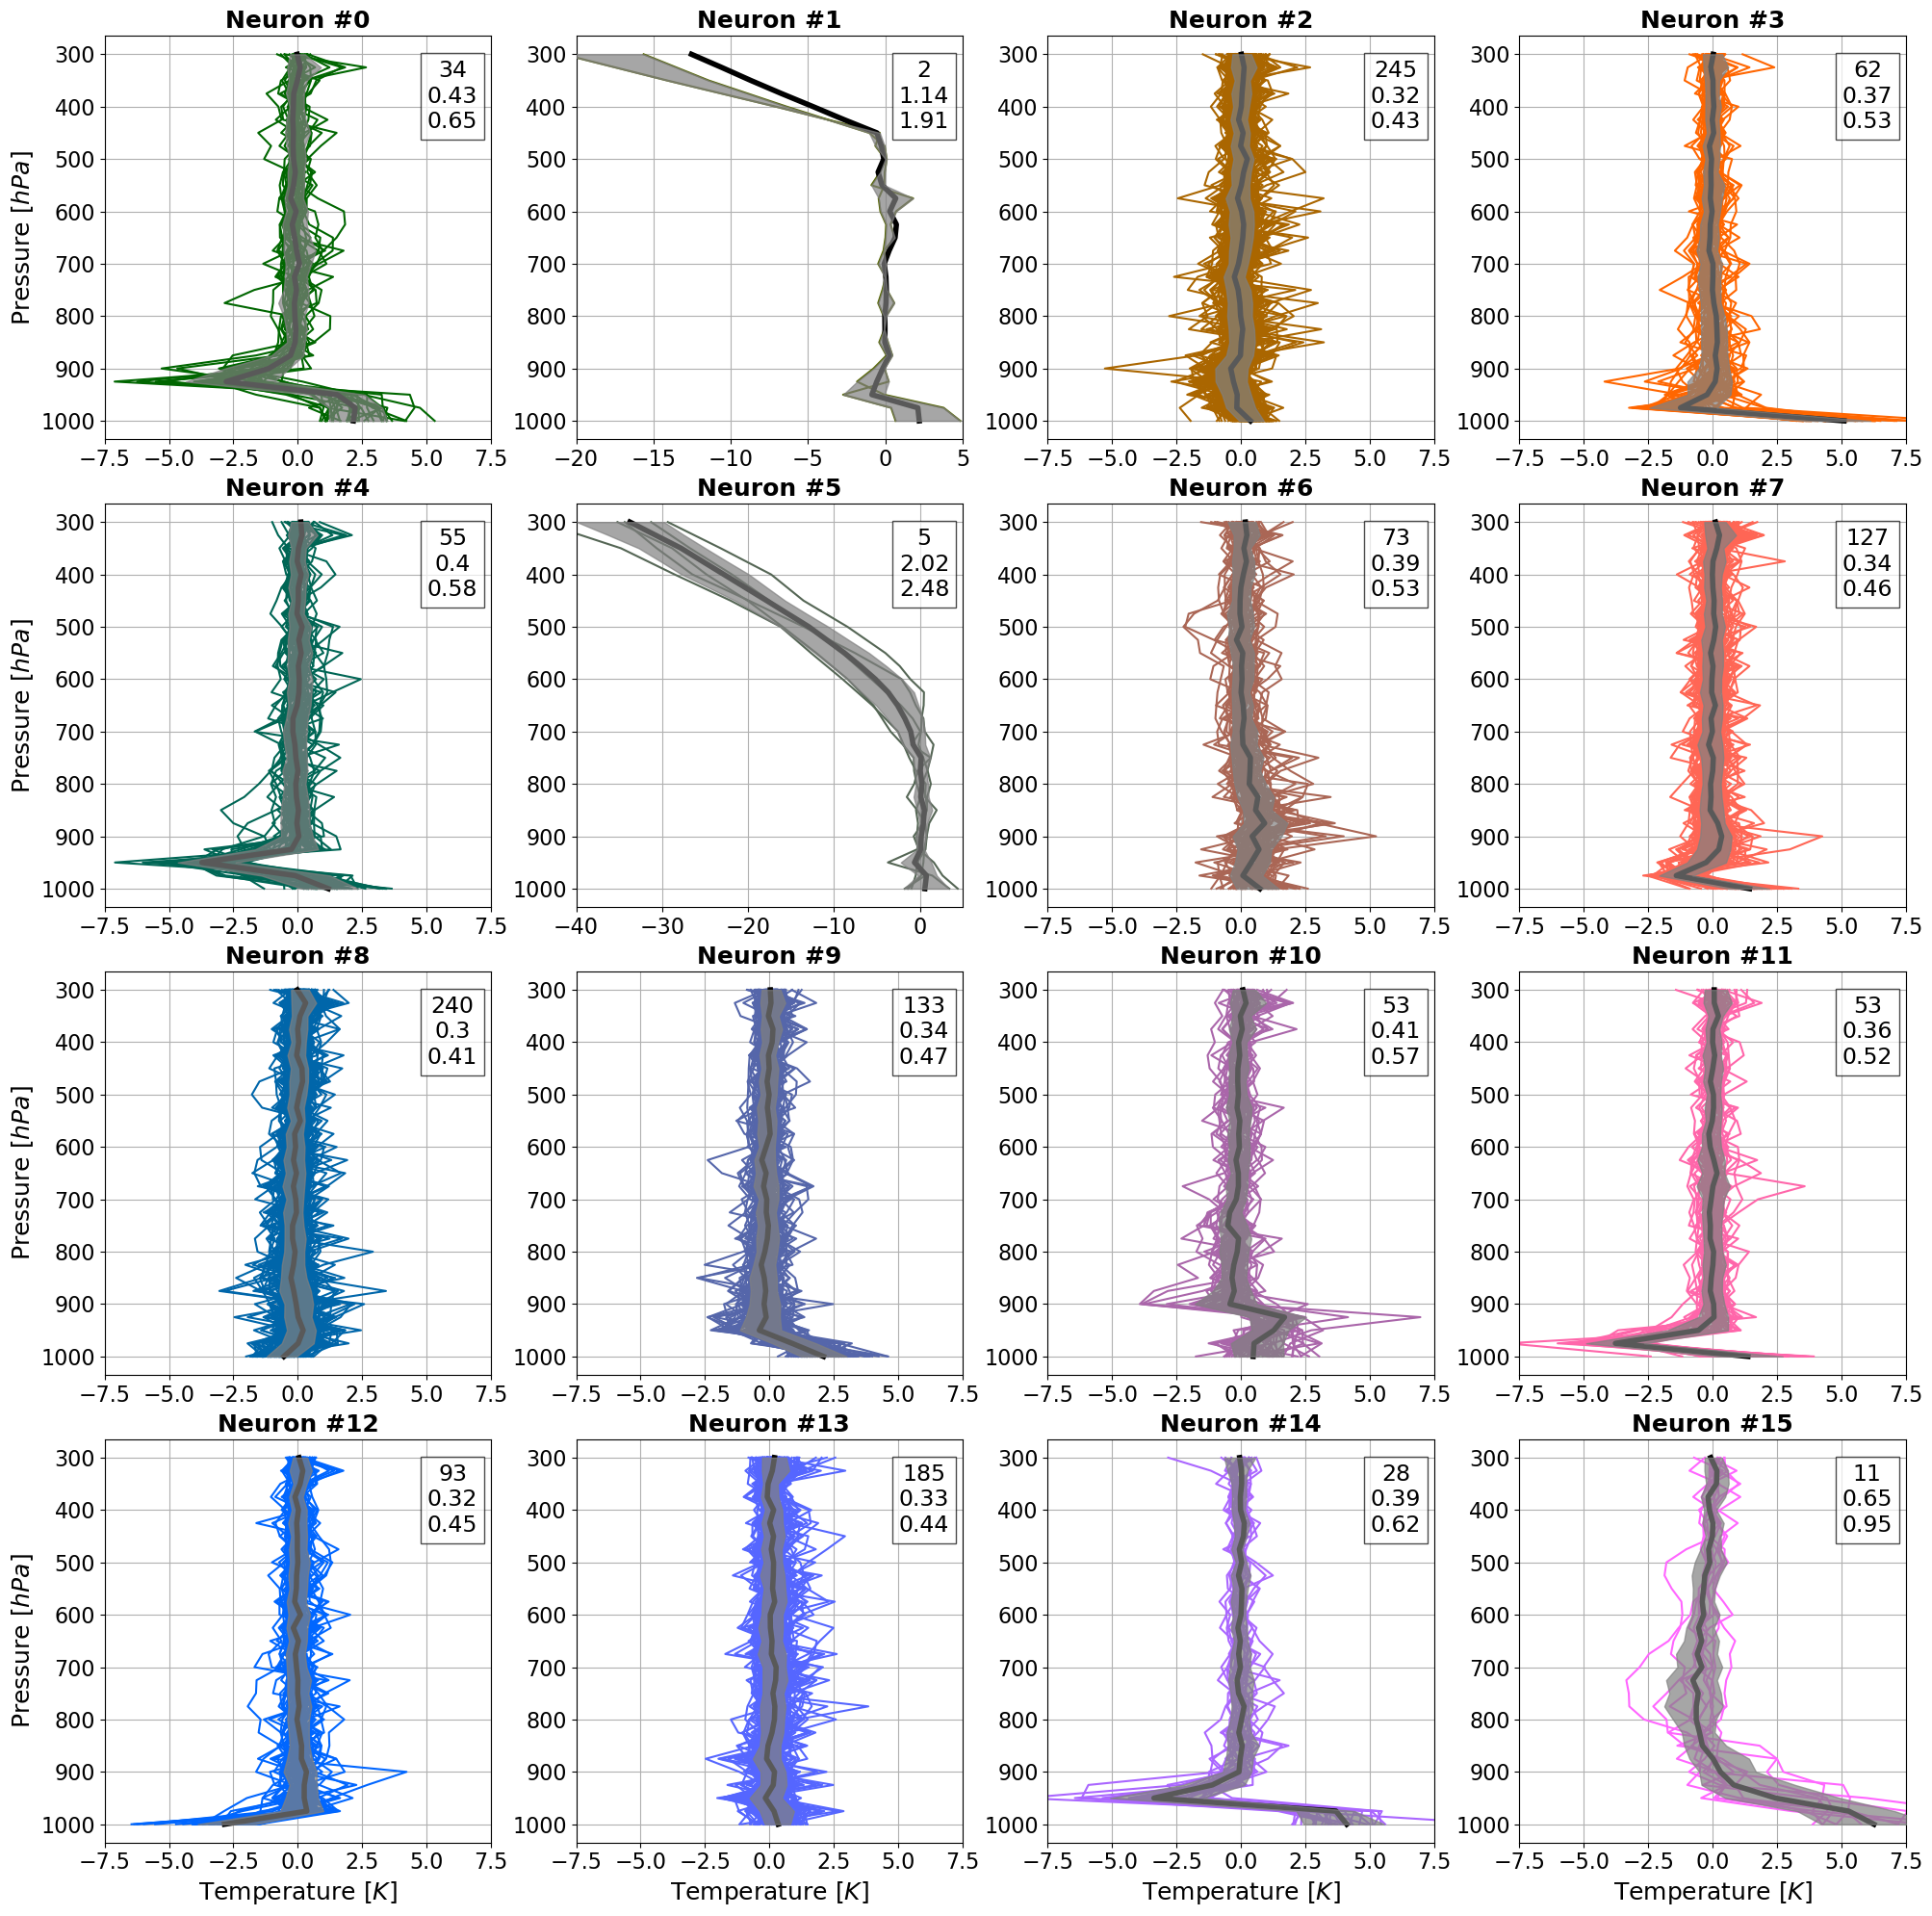

In [24]:
parameters = {'axes.labelsize':18, 'axes.titlesize':18, 'legend.fontsize':17, 'xtick.labelsize':16, 'ytick.labelsize':16, 
                  'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
      
fig, axs = plt.subplots(x,y,figsize=(20,20))
red = np.linspace(0,1,4)
blue = np.linspace(0,1,4)
n=0

for i in range(0,x) :
     for j in range(0,y) :
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        axs[i,j].fill_betweenx(pres, std_min_neuron_list[neuron_name], std_max_neuron_list[neuron_name], alpha = 0.7, edgecolor='grey', facecolor='grey', zorder=3)
        for p in range(len(win_map[(i,j)])) :
            axs[i,j].plot(win_map[(i,j)][p], pres, color=(red[j], 0.4, blue[i]))
            if p==0 :
                bbox_props = dict(boxstyle='square', facecolor='white', edgecolor='black', alpha=0.7)
                axs[i, j].text(0.9, 0.85, '{}\n{}\n{}'.format(int(nb_profiles[i][j]),np.round(mae_neuron[n], 2),np.round(rmse_neuron[n], 2)),
                horizontalalignment='center', verticalalignment='center', transform=axs[i, j].transAxes,fontsize=17,bbox=bbox_props)
        axs[i,j].plot(neuron_weights[i][j], pres, 'k', linewidth='4')
        axs[i,j].invert_yaxis()
        axs[i,j].grid()
        axs[i,j].set_xlim(-7.5,7.5)
        axs[i,j].set_title('Neuron #'+str(n), weight='bold')
        if j==0 :
            axs[i,j].set_ylabel('Pressure [$hPa$]')
        if i>2 :
            axs[i,j].set_xlabel('Temperature [$K$]')                     
        n=n+1
axs[0,1].set_xlim(-20,5)
axs[1,1].set_xlim(-40,5)         
fig.tight_layout()        
fig.subplots_adjust(hspace=0.16)

path_fig = '/home/jcharrel/Documents/M1_internship/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_SOM/'
plt.savefig(path_fig+'ERA5_MOSAIC_bias_temp_'+str(x*y)+'_s'+str(sigma)+'_lt'+str(learning_rate)+'_i'+str(iterations)+'_SOM.png',dpi=300, facecolor='white', transparent=False)

In [25]:
corresponding_data = sh_bias
corresponding_neuron_list = {}
for i in range(0,x) :
     for j in range(0,y) :
            neuron_name = 'neuron_'+str(i)+'_'+str(j)
            corresponding_neuron_list[neuron_name] = []
for p in range(0,len(corresponding_data)) :
    i = winner_list[p][0]
    j = winner_list[p][1]
    neuron_name = 'neuron_'+str(i)+'_'+str(j)
    corresponding_neuron_list[neuron_name].append(corresponding_data[p].tolist())
    
mean_neuron_list = {} ; std_neuron_list = {} ; std_min_neuron_list = {} ; std_max_neuron_list = {}

for i in range(0,x) :
     for j in range(0,y) :
            neuron_name = 'neuron_'+str(i)+'_'+str(j)
            mean_neuron_list[neuron_name] = []
            std_neuron_list[neuron_name] = []
            std_min_neuron_list[neuron_name] = []
            std_min_neuron_list[neuron_name] = []
            mean = [] ; std = [] ; std_min = [] ; std_max = []
            for lev in range(0,len(pres)) :
                liste=[]
                for p in range(0,len(corresponding_neuron_list[neuron_name])) :
                    liste.append(corresponding_neuron_list[neuron_name][p][lev])
                    #print(p,lev)
                mean.append(np.mean(liste))
                std.append(np.std(liste))
                std_min.append(np.mean(liste)-np.std(liste))
                std_max.append(np.mean(liste)+np.std(liste))
            mean_neuron_list[neuron_name] = mean
            std_neuron_list[neuron_name] = std
            std_min_neuron_list[neuron_name] = std_min
            std_max_neuron_list[neuron_name] = std_max

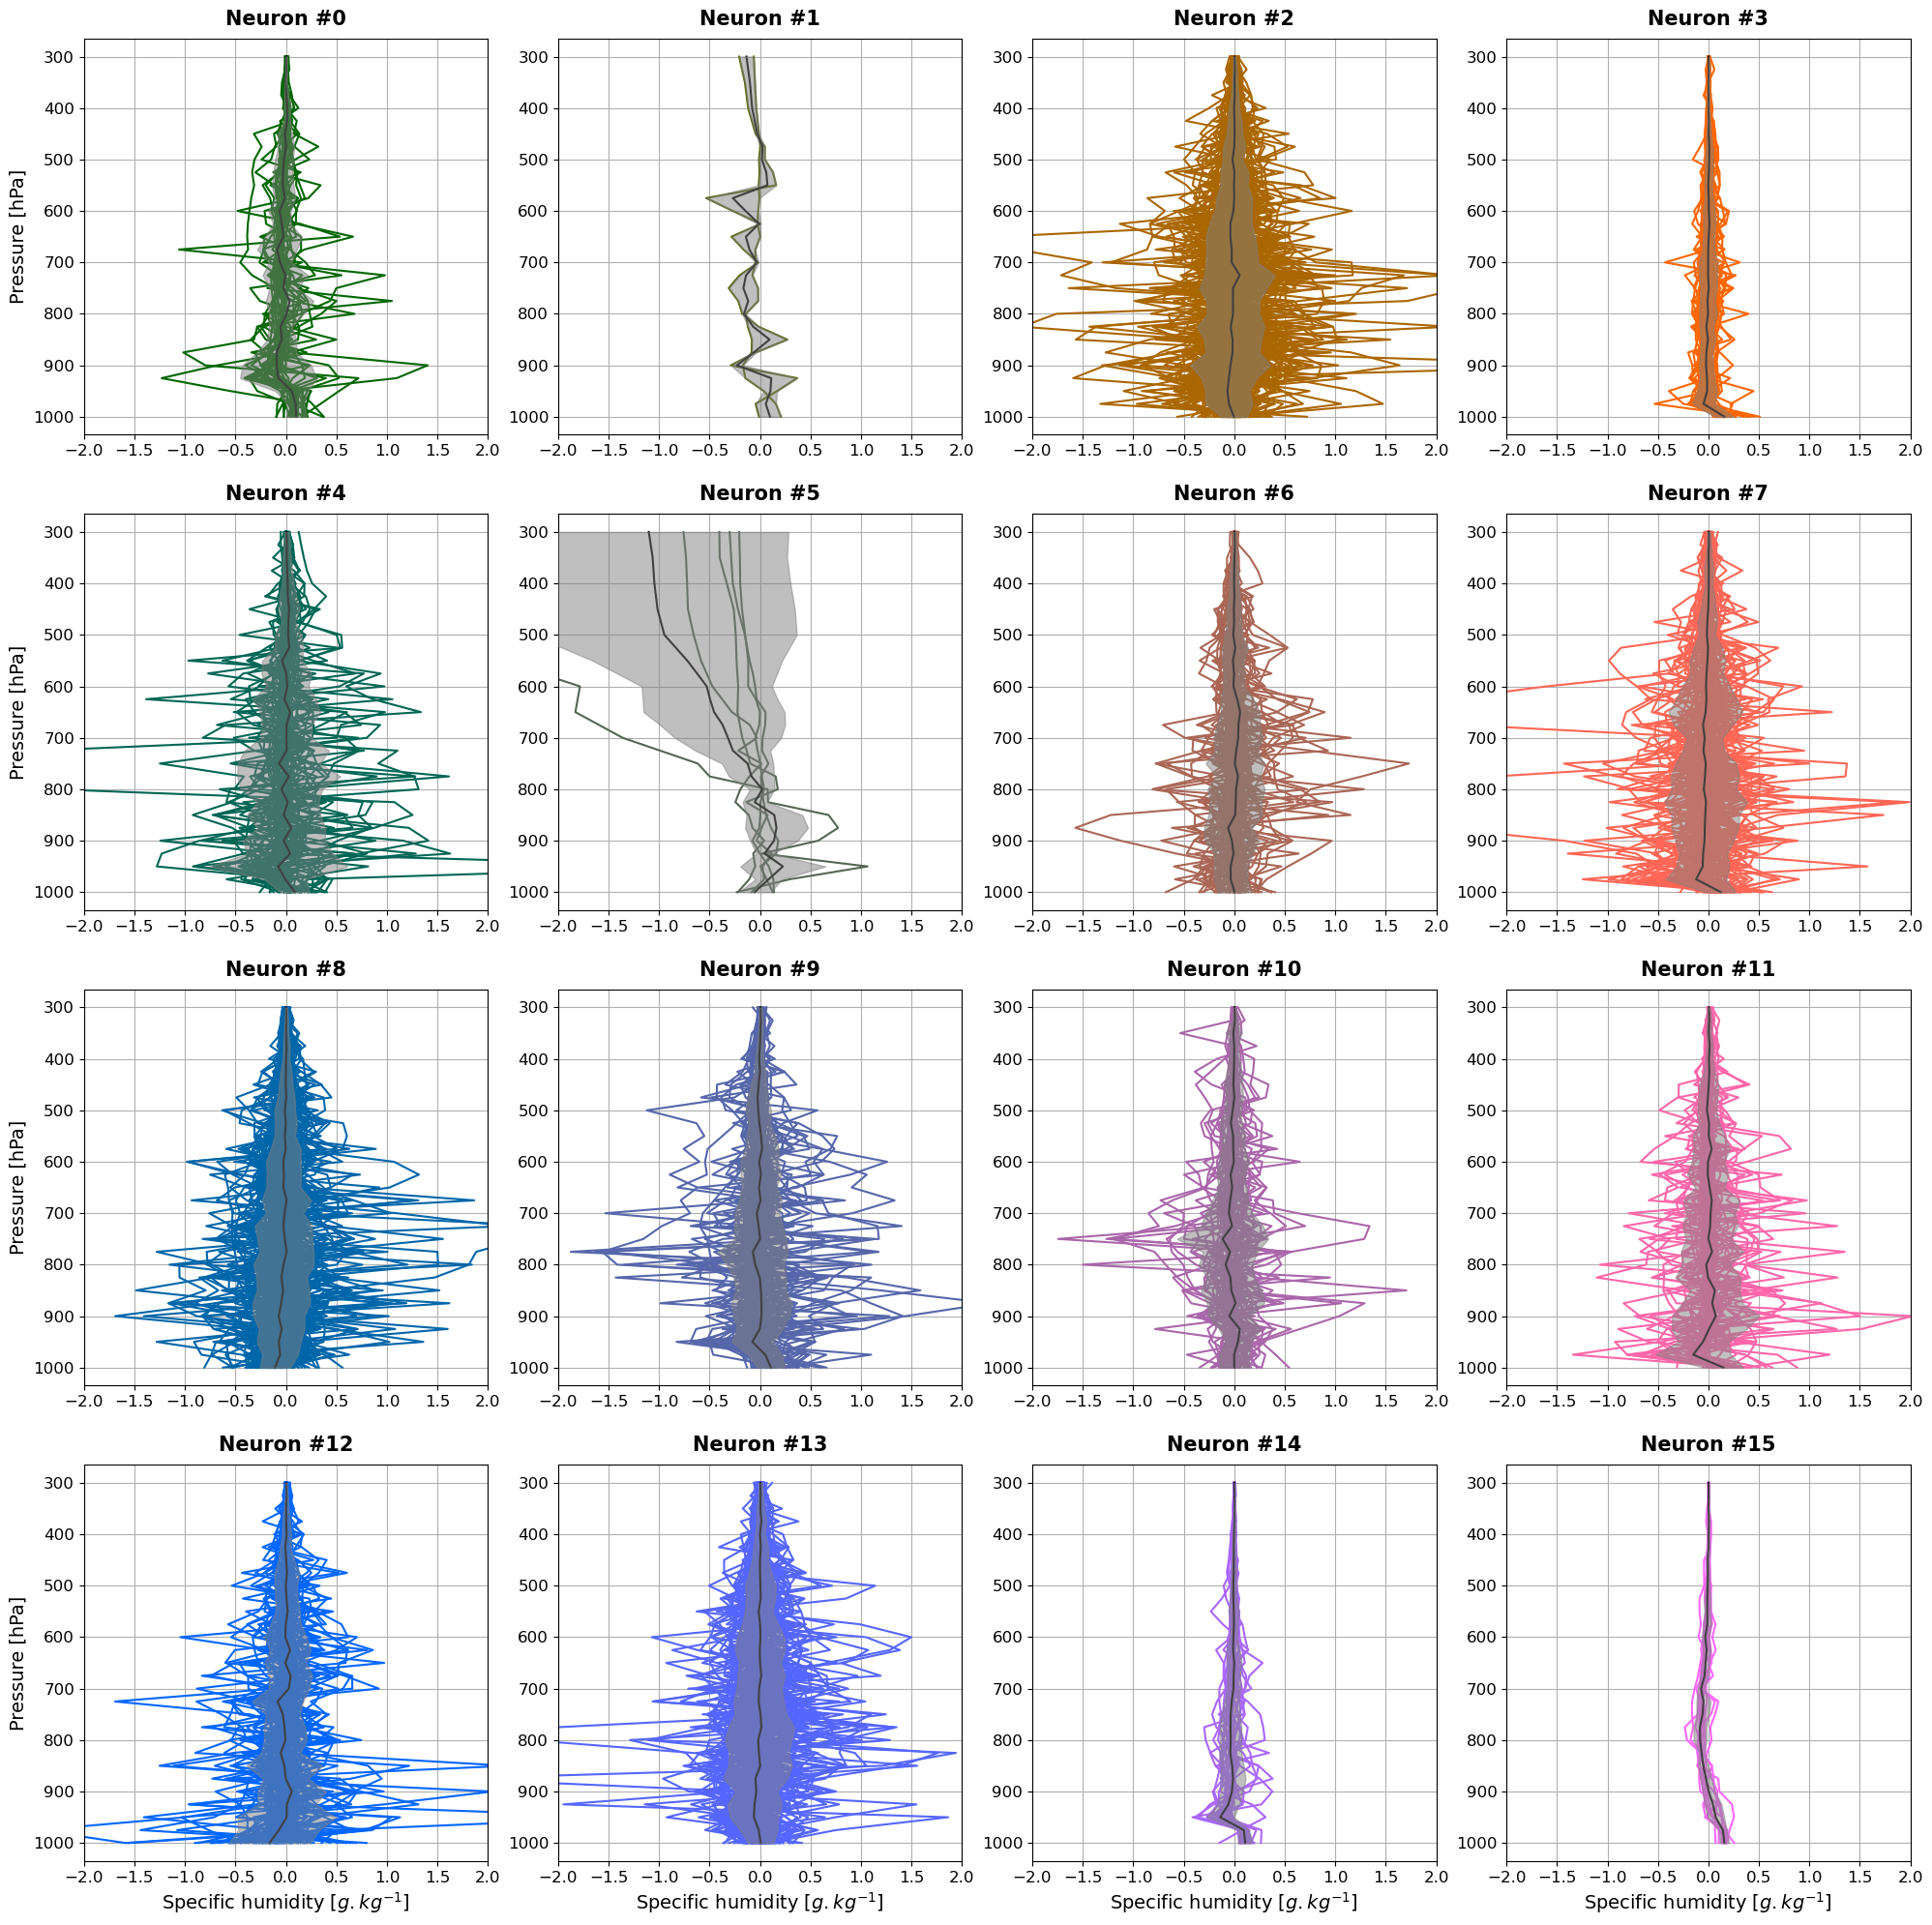

In [28]:
parameters = {'axes.labelsize':14, 'axes.titlesize':15, 'legend.fontsize':16, 'xtick.labelsize':12, 'ytick.labelsize':12, 
                  'legend.title_fontsize':14, 'figure.titlesize':25}
plt.rcParams.update(parameters)
      
fig, axs = plt.subplots(x,y,figsize=(20,20))
red = np.linspace(0,1,4)
blue = np.linspace(0,1,4)

for p in range(0,len(corresponding_data)) :
    i = winner_list[p][0]
    j = winner_list[p][1]
    axs[i,j].plot(corresponding_data[p], pres, color=(red[j], 0.4, blue[i]))
    axs[i,j].set_xlim(-2,2)
    
n=0
for i in range(0,x) :
     for j in range(0,y) :
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        axs[i,j].plot(mean_neuron_list[neuron_name], pres, color='k') # a changer
        axs[i,j].fill_betweenx(pres, std_min_neuron_list[neuron_name], std_max_neuron_list[neuron_name], alpha = 0.5, edgecolor='grey', facecolor='grey', zorder=3)
        axs[i,j].invert_yaxis()
        axs[i,j].grid()
        axs[i,j].set_title('Neuron #'+str(n), pad=10, weight='bold')
        if j==0 :
            axs[i,j].set_ylabel('Pressure [hPa]')
        if i>2 :
            axs[i,j].set_xlabel('Specific humidity [$g.kg^{-1}$]')
        n=n+1
        
fig.tight_layout()        
fig.subplots_adjust(hspace=0.2)

path_fig = '/home/jcharrel/Documents/M1_internship/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_SOM/'
plt.savefig(path_fig+'ERA5_MOSAIC_bias_temp_corresponding_sh_bias_'+str(x*y)+'_s'+str(sigma)+'_lt'+str(learning_rate)+'_i'+str(iterations)+'_SOM.png',dpi=300, facecolor='white', transparent=False)

### PLOT COLOR OF PROFILES OVER TIME

In [29]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

In [30]:
# Create dictionaries with neuron_name being the corresponding neuron
time_neuron_list = {}
for i in range(0,x):
    for j in range(0,y):
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        time_neuron_list[neuron_name] = []
        indices = find_indices(winner_list, (i,j))
        time_neuron = [nctime[0][ind] for ind in indices]
        time_neuron_list[neuron_name] = time_neuron

In [31]:
# to have the dates of profiles in a neuron
# time_neuron_list['neuron_1_1']

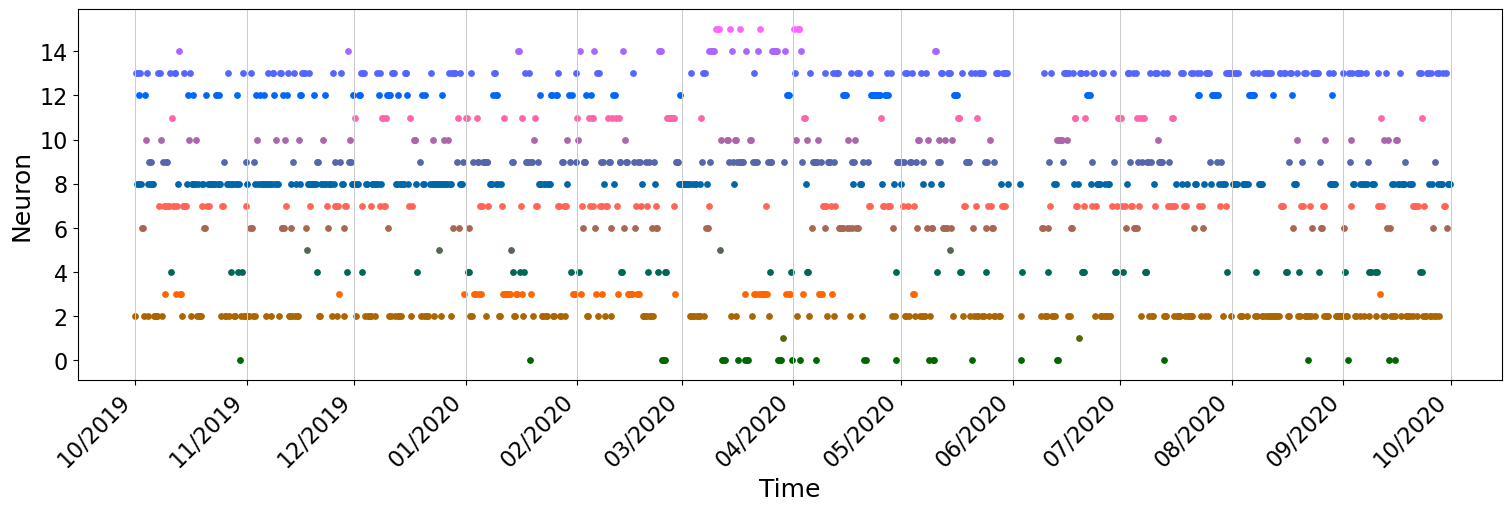

In [32]:
parameters = {'axes.labelsize':18, 'axes.titlesize':18, 'legend.fontsize':17, 'xtick.labelsize':16, 'ytick.labelsize':16, 
                  'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
fig = plt.figure(figsize=(15,5), constrained_layout=True)
ax = fig.add_subplot(111)
n=0 ; count=0
for i in range(0,x):
    for j in range(0,y):
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        for p in range(0,len(time_neuron_list[neuron_name])) :
            plt.scatter(time_neuron_list[neuron_name][p][0], [n], s=15, color=(red[j], 0.4, blue[i]))
            count=count+1
        n=n+1
plt.ylabel('Neuron')
plt.xlabel('Time')
plt.ylim(-0.9,15.9)
plt.yticks(np.arange(0,16,2))
plt.xlim([datetime.date(2019, 9, 15), datetime.date(2020, 10, 15)])
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%Y'))
ax.xaxis.set_major_locator(dates.MonthLocator())
months_date = pd.date_range('2019-09-01','2020-11-01' , freq='1M')-pd.offsets.MonthBegin(1)
for i in range(0,4) :
    for j in range(0,len(months_date)) :
        plt.axvline(months_date[j], color='#CCCCCC', linestyle='-', linewidth='0.5')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
path_fig = '/home/jcharrel/Documents/M1_internship/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_SOM/'
plt.savefig(path_fig+'ERA5_MOSAIC_bias_temp_'+str(x*y)+'_s'+str(sigma)+'_lt'+str(learning_rate)+'_i'+str(iterations)+'_timeserie.png',dpi=300, facecolor='white', transparent=False)

### PLOT COLOR OF PROFILES OVER LATITUDE AND LONGITUDE

In [33]:
list_color=[]
for i in range(0,x):
    for j in range(0,y):
        list_color.append((red[j], 0.4, blue[i]))

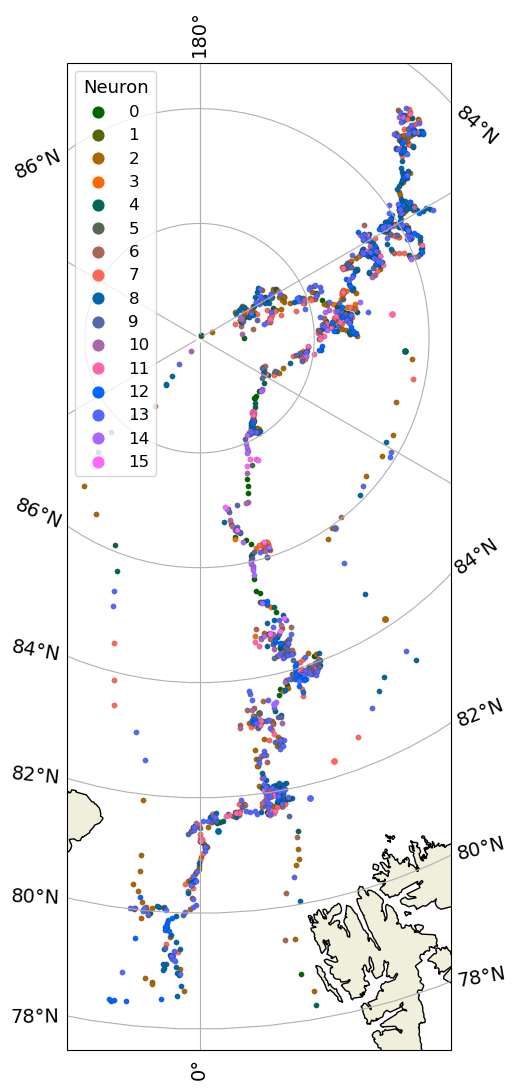

In [38]:
import matplotlib.ticker as mticker
parameters = {'axes.labelsize':18, 'axes.titlesize':18, 'legend.fontsize':12, 'xtick.labelsize':16, 'ytick.labelsize':16, 
                  'legend.title_fontsize':13, 'figure.titlesize':25}
plt.rcParams.update(parameters)
fig = plt.figure(figsize=(5,11)) #10x20 stereo , #20x20 lambert
ax = plt.axes(projection=cartopy.crs.Stereographic(central_latitude = 90, central_longitude = 0))
#ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0.0, globe=None))
#ax = plt.axes(projection=cartopy.crs.LambertConformal(central_longitude = 0, central_latitude = 90))

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 14}  # Taille des labels de l'axe x
gl.ylabel_style = {'size': 14}  # Taille des labels de l'axe y
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
#ax.set_extent([mosaic_lon.min(), mosaic_lon.max(), mosaic_lat.min(), mosaic_lat.max()], crs=cartopy.crs.PlateCarree())

lat_neuron_list = {}
lon_neuron_list = {}
n=0
list_labels=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']
for i in range(0,x):
    for j in range(0,y):
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        lat_neuron_list[neuron_name] = []
        lat_neuron_list[neuron_name] = []
        indices = find_indices(winner_list, (i,j))
        lat_neuron = [mosaic_lat[ind] for ind in indices]
        lon_neuron = [mosaic_lon[ind] for ind in indices]
        lat_neuron_list[neuron_name] = lat_neuron
        lon_neuron_list[neuron_name] = lon_neuron
        for p in range(0,len(lat_neuron_list[neuron_name])) :
            ax.scatter(lon_neuron_list[neuron_name][p][0], lat_neuron_list[neuron_name][p][0], marker='o', s=15, edgecolor='k', linewidth=0.1, color=(red[j], 0.4, blue[i]), transform=cartopy.crs.PlateCarree())
        temp = ax.scatter(lon_neuron_list[neuron_name][p][0], lat_neuron_list[neuron_name][p][0], marker='o', s=15, color=list_color[n], transform=cartopy.crs.PlateCarree(), label=list_labels[n])
        n=n+1
ax.legend(title='Neuron', markerscale=2., loc='upper left')
temp.remove()
fig.tight_layout()
path_fig = '/home/jcharrel/Documents/M1_internship/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_SOM/'
plt.savefig(path_fig+'ERA5_MOSAIC_bias_temp_'+str(x*y)+'_s'+str(sigma)+'_lt'+str(learning_rate)+'_i'+str(iterations)+'_map.png',dpi=300, facecolor='white', transparent=False)

### SAVE SOM MODEL

In [17]:
#path_som = '/lustre/storeB/users/justinec/master_internship/data/SOM/'
#with open(path_som + 'som_era5_mosaic_bias_temp.p', 'wb') as outfile:
#    pickle.dump(som, outfile)

### BONUS

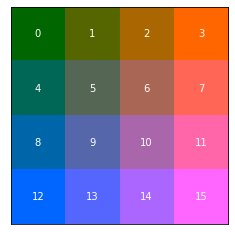

In [110]:
# To plot a grid map with the colors of radisondes profiles in each neuron

palette=[]
for i in range(0,x):
    for j in range(0,y):
        palette.append([red[j], 0.4, blue[i]])
palette = np.array(palette)
I = np.array([[ 0, 1, 2, 3],
              [ 4, 5, 6, 7],
              [ 8, 9, 10, 11],
              [ 12, 13, 14, 15]])
RGB = palette[I]
plt.imshow(RGB)
plt.yticks([]) #axs[0][1].set_yticks([])
plt.xticks([]) #axs[0][1].set_xticks([])
n=0
for i in range(0,x):
    for j in range(0,y):
        plt.text(j, i, str(n), color='white', va='center', ha='center')
        n=n+1